# How to evaluate a GraphRAG application

This example uses [Langchain](https://www.langchain.com) and [Giskard](https://github.com/Giskard-AI/giskard) to evaluate the quality of GraphRAG applications. A set of Chinese documents is used to build a knowledge base, from which a set of questions are created automatically. Behind the scene, these questions are fed to GPT4. Answers from the model under evaluation are compared with GPT4 answers, and performance of the model under test is evaluated based on the comparison results.

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
MODEL = "gpt-3.5-turbo"

# Load documents
Load documents from input folder, and split them into chunks of 1024 bytes.

In [ ]:
#from langchain.document_loaders import TextLoader
from langchain_community.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Step 1: Load all txt documents in input folder
loader = DirectoryLoader("./input/", glob="**/*.txt")
docs = loader.load()

# Step 2: Split documents into Chunks (returns List[Document])
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=24)
documents = text_splitter.split_documents(docs)  # This is already a list of Document objects

2025-02-25 18:19:12,169 pid:62268 MainThread unstructured WARNING  libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
2025-02-25 18:19:12,193 pid:62268 MainThread unstructured WARNING  libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
2025-02-25 18:19:12,237 pid:62268 MainThread unstructured WARNING  libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.


## Load the Content to Vector Store

In [ ]:
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import DocArrayInMemorySearch

vectorstore = DocArrayInMemorySearch.from_documents(
    documents, embedding=OpenAIEmbeddings()
)

## Create a Knowledge Base
Create a Pandas DataFrame from the content and then use the dataframe to contruct a knowledge base.

In [ ]:
import pandas as pd

df = pd.DataFrame([d.page_content for d in documents], columns=["text"])
df.head(10)

from giskard.rag import KnowledgeBase

knowledge_base = KnowledgeBase(df)

,text
0,## 作者 朱自清 :\n\n这几天心里颇不宁静。今晚在院子里坐着乘凉，忽然想起日日 走过的...
1,带远山，只有些 大意罢了。树缝里也漏着\n\n两点路灯光，没精打采的，是渴睡人的 眼。这时候...
2,## 作者 朱自清 :\n\n我与父亲不相见已二年余了，我最不能忘记的是他的背影。那 年冬天...
3,个胖子，走过去自然要费事些。我本来要去的，他\n\n不肯，只好让他去。我看见他戴着黑布小帽，...
4,## 作者 朱自清 :\n\n九二三年八月的\n\n晚，我和平伯同游秦淮河；平伯是初泛， 我...
5,秦淮河的水是碧阴阴的；看起来厚而不腻，或者是六朝金粉所 凝么？我们初上船的时候，天色还未断黑...
6,大中桥外，本来还有-座复成桥，是船夫口中的我们的游踪尽处， 或也是秦淮河繁华的尽处了。我的脚...
7,派清辉，却真是奇迹!那晚月儿已瘦削 了两三分。她晚妆才罢，盈盈的上了柳梢头。天是蓝得可爱，仿...
8,我们的船并着了。铄铄的灯光逼得我们皱起了眉头；我们的风尘色 全给它托出来了，这使我踧踖不安了...
9,倒了我的听歌的盼望，这便成就了我的灰色的拒绝。那时的心实在 异常状态中，觉得颇是昏乱。歌舫去...


## Generate a Test Set

In [ ]:
from giskard.rag import generate_testset

testset = generate_testset(
    knowledge_base,
    num_questions=10,
    agent_description="哈佛大学汉语研究员查问有关朱自清散文的问题",
)

Generating questions: 100%|██████████| 10/10 [00:39<00:00,  3.95s/it]


Display a sample from the test set.

In [ ]:
test_set_df = testset.to_pandas()

for index, row in enumerate(test_set_df.head(3).iterrows()):
    print(f"Question {index + 1}: {row[1]['question']}")
    print(f"Reference answer: {row[1]['reference_answer']}")
    print("Reference context:")
    print(row[1]['reference_context'])
    print("******************", end="\n\n")


Question 1: What traditional activity does the author reminisce about in the context?
Reference answer: The author reminisces about the traditional activity of lotus picking, which was a custom in Jiangnan, particularly popular during the Six Dynasties period.
Reference context:
Document 1: 带远山，只有些 大意罢了。树缝里也漏着

两点路灯光，没精打采的，是渴睡人的 眼。这时候最热闹的，要数树上的蝉声与水里的蛙声；但热闹是它 们的，我什么也没有。

忽然想起采莲的事情来了。采莲是江南的旧俗，似乎很早就 有，而六朝时为盛；从诗歌里可以约略知道。采莲的是少年的女 子，她们是荡着小船，唱着艳歌去的。采莲人不用说很多，还有看 采莲的人。那是

个热闹的季节，也是

个风流的季节。梁元帝 《采莲赋》里说得好：

于是妖童媛女，荡舟心许；鷁首徐回，兼传羽杯；欋将移而藻 挂，船欲动而萍开。尔其纤腰束素，迁延顾步；夏始春余，叶嫩花 初，恐沾裳而浅笑，畏倾船而敛裾。

可见当时嬉游的光景了。这真是有趣的事，可惜我们现在早已 无福消受了。

于是又记起《西洲曲》里的句子：

采莲南塘秋，莲花过人头；低头弄莲子，莲子清如水。今晚若 有采莲人，这儿的莲花也算得'过人头'了；只不见

些流水的影 子，是不行的。这令我到底惦着江南了。-

这样想着，猛

抬 头，不觉已是自己的门前；轻轻地推门进去，什么声息也没有，妻 已睡熟好久了。

1927 年 7 月，北京清华园。
******************

Question 2: What does the author describe the lotus leaves and flowers as resembling in the moonlight?
Reference answer: The author describes the lotus leaves and flowers as resembling a dancer's skirt,

Save the test set to an external file:

In [ ]:
testset.save("test-set.jsonl")

## Prepare the Prompt Template

In [ ]:
from langchain.prompts import PromptTemplate

template = """
以下面提供的背景为基础，回答问题。如果没有足够信息回答提出的问题，就回答“不知道”。

Context: {context}

Question: {question}
"""

prompt = PromptTemplate.from_template(template)
print(prompt.format(context="背景", question="问题"))


以下面提供的背景为基础，回答问题。如果没有足够信息回答提出的问题，就回答“不知道”。

Context: 背景

Question: 问题



## Create the RAG Chain

A retriever is created from the Vector Store. The retriever will retrieve the top similar documents to a given question.

In [ ]:
retriever = vectorstore.as_retriever()
retriever.get_relevant_documents("这三篇文章应该归类成什么体裁?")

[Document(page_content="个胖子，走过去自然要费事些。我本来要去的，他\n\n不肯，只好让他去。我看见他戴着黑布小帽，穿着黑布大马褂，深 青布棉袍，蹒跚地走到铁道边，慢慢探身下去，尚不大难。可是他 穿过铁道，要爬上那边月台，就不容易了。他用两手攀着上面，两 脚再向上缩；他肥胖的身子向左微倾，显出努力的样子。这时我看 见他的背影，我的泪很快地流下来了。我赶紧拭干了泪，怕他看 见，也怕别人看见。我再向外看时，他已抱了朱红的橘子望回走 了。过铁道时，他先将橘子散放在地上，自己慢慢爬下，再抱起橘 子走。到这边时，我赶紧去搀他。他和我走到车上，将橘子-股脑 儿放在我的皮大衣上。于是扑扑衣上的泥土，心里很轻松似的，过 -会说，'我走了；到那边来信!'我望着他走出去。他走了几 步，回过头看见我，说，'进去吧，里边没人。'等他的背影混入 来来往往的人里，再找不着了，我便进来坐下，我的眼泪又来了。\n\n近几年来，父亲和我都是东奔西走，家中光景是-日不如- 日。他少年出外谋生，独力支持，做了许多大事。那知老境却如此 颓唐!他触目伤怀，自然情不能自已。情郁于中，自然要发之于 外；家庭琐屑便往往触他之怒。他待我渐渐不同往日。但最近两年 的不见，他终于忘却我的不好，只是惦记着我，惦记着我的儿子。 我北来后，他写了-信给我，信中说道，'我身体平安，惟膀子疼 痛利害，举箸提笔，诸多不便，大约大去之期不远矣。'我读到此 处，在晶莹的泪光中，又看见那肥胖的，青布棉袍，黑布马褂的背 影。唉!我不知何时再能与他相见!\n\n1925 年 10 月在北京。", metadata={'source': 'input/beiying_zhuziqing_utf8.txt'}),
 Document(page_content="带远山，只有些 大意罢了。树缝里也漏着\n\n两点路灯光，没精打采的，是渴睡人的 眼。这时候最热闹的，要数树上的蝉声与水里的蛙声；但热闹是它 们的，我什么也没有。\n\n忽然想起采莲的事情来了。采莲是江南的旧俗，似乎很早就 有，而六朝时为盛；从诗歌里可以约略知道。采莲的是少年的女 子，她们是荡着小船，唱着艳歌去的。采莲人不用说很多，还有看 采莲的人。那是\n\n个热闹的季节，也是\n\n个风流的季节。梁元帝 《采莲赋》里说得好：\n\n于是妖童媛女，荡舟心许；鷁首

Create a rag chain.

In [ ]:
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

model = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model=MODEL)

chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
    }
    | prompt
    | model
    | StrOutputParser()
)

Try a simple question to test the rag chain.

In [ ]:
chain.invoke({"question": "简略介绍朱自清散文的风格"})

'朱自清的散文风格清新自然，富有诗意和感情，善于通过细腻的描写展现内心世界，情感真挚而深沉。他的散文常以平实的语言表达内心的感悟和情感体验，充满对自然、生活和人情的独特感悟，具有一种温暖、朴实的风格。'

## Evaluating the Model with the Test Set

Define the function that invokes the rag chain with a specific question and returns the answer.

In [ ]:
def answer_fn(question, history=None):
    return chain.invoke({"question": question})

Call Giskard's `evaluate()` function to evaluate the model with the test set. This function compares the answers from the chain with the reference answers in the test set.

In [ ]:
from giskard.rag import evaluate

report = evaluate(answer_fn, testset=testset, knowledge_base=knowledge_base)

CorrectnessMetric evaluation: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


Display the test report.

The five components of our GraphRAG application:

* **Generator**: This is the LLM that generates the answers.
* **Retriever**: The component that fetches relevant documents from the knowledge base based on query.
* **Rewriter**: The component that rewrites the user query to make it more relevant to the knowledge base or to account for chat history.
* **Router**: The component that filters the user's query based on his intentions.
* **Knowledge Base**: The set of documents that is given to the LLM which uses them to augment the answers.

Generation and rendering of performance evaluation requires that BokehJS be dynamically loaded, which GitHub doesn't support as of now. So instead, a picture was taken of the performance report diagram, and then it is statically inserted in the notebook.

File exists: True


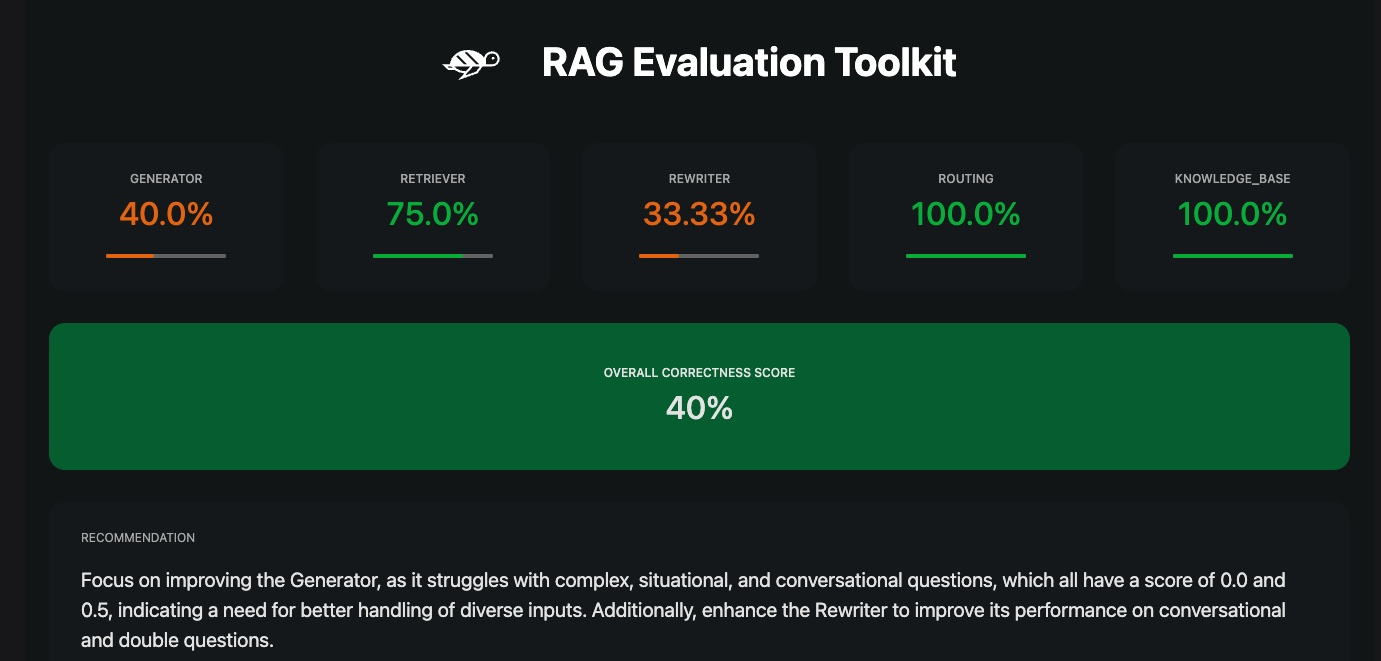

In [7]:
import os
print("File exists:", os.path.exists("graphrag_eval.png"))

from IPython.display import Image, display

display(Image(filename="graphrag_eval.png"))

In [ ]:
display(report)

Loading BokehJS ...